In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from collections import Counter
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score,  log_loss, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import os
import tensorflow as tf
from keras.layers import Dense, Flatten, InputLayer, Dropout, Input
from tensorflow.keras import Sequential, Model

from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datatable as dt

# This notebook is based on the paper : Classification of mislabelled microarrays using robust sparse logistic regression

**[https://academic.oup.com/bioinformatics/article/29/7/870/253956](http://)**

In [ ]:
data_folder = '/kaggle/input/tabular-playground-series-nov-2021/'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
seed = 2021
print("Tensorflow Number of GPUs Available: ",len(tf.config.list_physical_devices('GPU')))

# Wrapper function to compute class balance

In [ ]:
def class_weight(target, smooth_factor=0):
    counter = Counter(target)
    if smooth_factor > 0:
        p = max(counter.values()) * smooth_factor
        for k in counter.keys():
            counter[k] += p
    majority = max(counter.values())
    return {cls: float(majority / count) for cls, count in counter.items()}

# Reduce memory usage by converting the dtypes

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(
        100 * (start_mem - end_mem) / start_mem))

    return df

# Use datatable to read CSV and convert to Pandas DF

In [ ]:
data_df = reduce_mem_usage(dt.fread(data_folder+'train.csv').to_pandas())
data_df.drop(['id'], axis=1, inplace=True)

test_data_df = reduce_mem_usage(dt.fread(data_folder+'test.csv').to_pandas())
test_data_df.drop(['id'], axis=1, inplace=True)

sample_submission = reduce_mem_usage(dt.fread(data_folder+'sample_submission.csv').to_pandas())

X_test = test_data_df.copy()

y = data_df['target']
temp = data_df.copy()
data_df.drop(['target'], axis=1, inplace=True)
temp_X = data_df.copy()

# Find the mislabelled classes with simple LogisticRegression and ignore those records

In [ ]:
# 'liblinear','newton-cg','lbfgs','sag','saga'
lr_model_1 = LogisticRegression(solver='liblinear')
lr_model_1.fit(temp_X, y)
prediction = lr_model_1.predict(temp_X)
temp['new_target'] = prediction
temp = temp[temp['target'] == temp['new_target']]

y = temp['target']
X = temp.copy()
X.drop(['target', 'new_target'], axis=1, inplace=True)

# Compute the unbiased varaince of features and ignore the features with high variance

In [ ]:
train_var = pd.DataFrame(X.var().reset_index()).rename(
    columns={'index': 'features', 0: 'var'}).sort_values('var', ascending=False).iloc[0:3, 0].to_list()

valid_cols = [col for col in X_test.columns if col not in train_var]
X = X[valid_cols]
X_test = X_test[valid_cols]

# Scale the selected features to the values between 0 and 1

In [ ]:
scaler = StandardScaler()

X = pd.DataFrame(columns=X.columns, data=scaler.fit_transform(X))
X_test = pd.DataFrame(columns=X_test.columns, data=scaler.transform(X_test))


# A simple NN with 3 layers

In [ ]:
def neural_model_1(train_features, name, activation, learning_rate):
    model = Sequential(name=name)
    model.add(InputLayer(input_shape=(train_features.shape[1])))
    model.add(Dense(128, activation=activation))
    model.add(Dropout(rate=0.5))
    model.add(Dense(64, activation=activation))
    model.add(Dropout(rate=0.5))
    model.add(Dense(32, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['AUC'])
    return model

# Train with 5 fold validation

In [ ]:
folds = 5
activation = 'swish'
batch_size = 2048
epochs = 100
learning_rate = 0.001

earlystop = EarlyStopping(monitor='val_loss', min_delta=0,
                          patience=20, verbose=0, mode='min', restore_best_weights=True)
plateau = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=7, verbose=0, mode='min')

callbacks_list = [earlystop, plateau]

cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

scores = {fold: None for fold in range(cv.n_splits)}
predictions = []

for fold, (idx_train, idx_valid) in enumerate(cv.split(X, y)):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    model = neural_model_1(
        X, name='Baseline', activation=activation, learning_rate=learning_rate)

    print('**'*20)
    print(f"Fold {fold+1} || Training")
    print('**'*20)

    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
                        batch_size=batch_size, epochs=epochs, verbose=0, callbacks=callbacks_list)
    scores[fold] = (history.history)
    print(
        f"Fold {fold+1} || Max Validation AUC: {np.max(scores[fold]['val_auc'])}")
    prediction = model.predict(X_test).reshape(1, -1)[0]
    predictions.append(prediction)

# The validation accuracy is 99+% after removing the mislabelled classes.If the test data is also mislabelled then it is just an overfitting :)

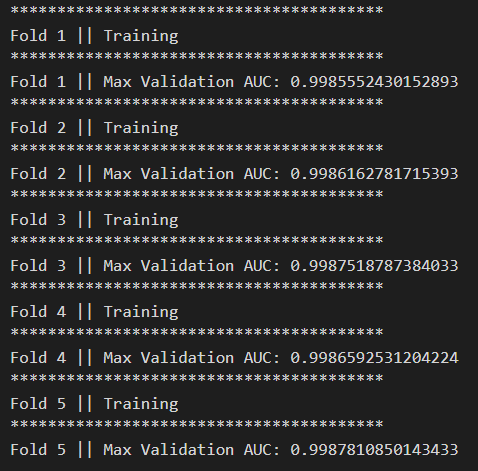

In [ ]:
sample_submission['target'] = np.mean(np.column_stack(predictions), axis=1)
sample_submission.to_csv('/kaggle/working/submission.csv', index=False)